0
0
0
0
[              inf       sus       rec
0    6.241238e-05  0.999915  0.000022
1    6.927301e-05  0.999888  0.000043
2    6.976875e-05  0.999864  0.000066
3    6.026576e-05  0.999850  0.000090
4    7.881302e-05  0.999812  0.000110
..            ...       ...       ...
195  4.992453e-30  0.999402  0.000598
196  3.328302e-30  0.999402  0.000598
197  2.218868e-30  0.999402  0.000598
198  1.479245e-30  0.999402  0.000598
199  9.861636e-31  0.999402  0.000598

[200 rows x 3 columns],               inf       sus       rec
0    5.714471e-05  0.999920  0.000022
1    5.349578e-05  0.999905  0.000041
2    5.055144e-05  0.999890  0.000059
3    4.405899e-05  0.999880  0.000076
4    3.700423e-05  0.999872  0.000091
..            ...       ...       ...
195  1.469235e-29  0.999773  0.000227
196  9.794900e-30  0.999773  0.000227
197  6.529933e-30  0.999773  0.000227
198  4.353289e-30  0.999773  0.000227
199  2.902192e-30  0.999773  0.000227

[200 rows x 3 columns],               inf       sus  

<function matplotlib.pyplot.close(fig=None)>

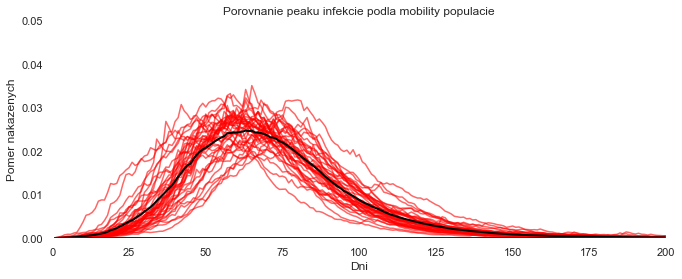

In [8]:
import sys
import numpy as np
import scipy.special as sps
from tqdm import tqdm_notebook
import pickle
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init as z
import simulate_corona as sc
import simulate_corona_senior as scs
import multiprocessing as mp
import load_part as lp
import helpers as hp


sns.set(rc={'figure.figsize':(11, 4)})

## definitions
out_filename_pct0 = "./out/simul_SIR_pct"
out_filename_raw0 = "./out/simul_SIR_raw"
scen_dir = ""
out_figname = "./fig/"
res_rootname = './out/'
stat_rootname = "./stat/"
patname = "simul_SIR_"

def load_data(suf):
    bx = lp.load_file_pickle(res_rootname,patname+"_raw_"+suf)
    with open(out_filename_pct0+"_"+suf+".pickle",'rb') as fid:
        ax = pickle.load(fid)
    fid.close()
    #print(out_filename_pct0+"_"+suf+".pickle")    
    return ax,bx
    
## load data
pct_SIR_high,SIR_high = load_data("high")
pct_SIR_med,SIR_med = load_data("med")
pct_SIR_low,SIR_low = load_data("low")

##  definitions of plotting and saving functions
def plot_peaks(data_arr,colname):
    avg_data = np.zeros(shape=(z.simul_len,1))
    k=0
    for data in (data_arr):
        plt.plot(x,data.inf[0:z.simul_len],c=colname,alpha=.6)
        plt.xlim((0,z.simul_len))
        plt.ylim((0,.05))
        avg_data[:,k]+=data.inf[0:z.simul_len]
    avg_data = (avg_data)/len(data_arr)
    plt.plot(x,avg_data[0:z.simul_len],c='black',alpha=1,linewidth=2)
        
def plot_infect_growth(data_arr,colname):
    for data in [sumlist(data_arr)[:,1,:].sum(0)]:
        plt.plot(x,data[1:lastday]-data[0:lastday-1],c=colname,alpha=1,linewidth=3)
        plt.xlim((0,lastday))
        plt.ylim((0,550000))
        
def export_res(data_arr,suf):
    opt = ["S","I","R"]
    for idx in opt:
        pd.DataFrame(sumlist(data_arr)[:,idx,:]).to_csv(stat_rootname+opt[idx]+"_"+suf+".csv")
        
        
## Plotting   

# 1. compare peaks (as a function of pop.mobility alpha), relative numbers
x = np.arange(1,z.simul_len+1)
plt.rcParams['axes.facecolor']='white'
plot_peaks(pct_SIR_high,'red')
plot_peaks(pct_SIR_med,'orange')
plot_peaks(pct_SIR_low,'green')
print(pct_SIR_med)
plot_peaks(pct_SIR_sen,'blue')
plt.title("Porovnanie peaku infekcie podla mobility populacie")
plt.xlabel("Dni")
plt.ylabel("Pomer nakazenych")
n = out_figname+scen_dir+"cmp_peak.png"
print(n)
plt.savefig(out_figname+scen_dir+"cmp_peaks.png",dpi=300)
plt.close

In [ ]:
# 2. compare growth of infectious persons (absolute numbers, daily basis)
x = np.arange(1,z.simul_len)
plt.rcParams['axes.facecolor']='white'
plot_infect_growth(SIR_high,'red')
plot_infect_growth(SIR_med,'orange')
plot_infect_growth(SIR_low,'green')
plot_infect_growth(SIR_sen,'blue')
plt.title("Denny narast poctu infikovanych")
plt.xlabel("Dni")
plt.ylabel("Pocet novych nakaz")
pls.subplots_adjust(left=.155)
plt.savefig(out_figname+scen_dir+"infect_growth.png".png",dpi=300)
plt.close
            
# 3. compare reported vs. all infected
dat = pd.DataFrame({'Vsetky pripady':np.concatenate([np.array(reported_cases),sumlist(SIR_low)[:,1,:].sum(0)]),
                   'Zachytene pripady':np.concatenate([[0,0,0,0,0],np.array(reported_cases),sumlist(SIR_low)[:,1,:].sum(0)[:-5]])})
x = np.arange(0,109)
plt.plot(x,dat['Zachytene pripady'],c='orange',alpha=1,linewidth=3)
plt.plot(x,dat['Vsetky pripady'],c='red',alpha=1,linewidth=3)
plt.xlim(0,45)
plt.ylim(0,10000)
plt.xlabel('Dni')
plt.ylabel('Pocet')
plt.legend(['Zachytene pripady','Vsetky pripady'])
plt.savefig(out_figname+scen_dir+"known_unknown.png",dpi=300)
    
## saving stuff
export_res(SIR_low,"low")
export_res(SIR_med,"med")
export_res(SIR_high,"high")
            
pct_SIR_high_avg=sumlist(pct_SIR_high)
print(pct_SIR_high_avg)
pct_SIR_med_avg=sumlist(pct_SIR_med)
print(pct_SIR_med_avg)
pct_SIR_low_avg=sumlist(pct_SIR_low)
print(pct_SIR_low_avg)

## reporting
# Infected & recovered (selected days, abs.numbers)
I_high=pd.read_csv(stat_rootname+"I_high.csv").iloc[:,1:].sum(0)
I_med=pd.read_csv(stat_rootname+"I_med.csv").iloc[:,1:].sum(0)
I_low=pd.read_csv(stat_rootname+"I_low.csv").iloc[:,1:].sum(0)

R_high=pd.read_csv(stat_rootname+"R_high.csv").iloc[:,1:].sum(0)
R_med=pd.read_csv(stat_rootname+"R_med.csv").iloc[:,1:].sum(0)
R_low=pd.read_csv(stat_rootname+"R_low.csv").iloc[:,1:].sum(0)

pd.DataFrame({'dni':np.arange(z.simul_len),
              'I_high':I_high.to_numpy() ,
              'R_high':R_high.to_numpy(),
              'I_med':I_med.to_numpy() ,
              'R_med':R_med.to_numpy(),
              'I_low':I_low.to_numpy() ,
              'R_low':R_low.to_numpy()  
             }).to_excel('IR_data.xlsx',engine='xlsxwriter')

I_high.iloc[[4,9,19,29,39,49,59,79,99,149,199]].to_numpy()